## Requisitos previos

Para la petición y lectura de los datos sismicos es necesario la libreria de obspy

In [1]:
try:
  from obspy.clients.fdsn import Client
except:
  %pip install obspy

Primero hay que importar las librerias necesarias

In [2]:
%matplotlib inline

from obspy.signal.trigger import trigger_onset, classic_sta_lta
from obspy.core.inventory.inventory import read_inventory
from datetime import datetime, timedelta
from matplotlib.gridspec import GridSpec
from IPython.display import display_png
from obspy.core.stream import Stream
import xml.etree.ElementTree as ET
from urllib.request import urlopen
from obspy.io.xseed import Parser
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from obspy import UTCDateTime
from obspy import read
import pandas as pd
import urllib.error
import numpy as np
import warnings
import os
import io

warnings.filterwarnings('ignore')

### Como utilizar UTCDateTime


UTCDateTime es una clase que permite manipular tipos de dato de tipo fecha y hora, donde se puede utlizar el ISO8601:2004 para el formato de fecha en strings de la siguiente manera:

Para representar una fecha se utiliza la sintaxis: `año-mes-dia`

Para representar una fecha y hora exacta se utiliza la sintaxis: `año-mes-diaThora:minuto:segundos`

In [437]:
print("Solo la fecha:", UTCDateTime('2019-09-20'))
print("Fecha y hora exacta:", UTCDateTime('2020-03-17T12:08:58'))

Solo la fecha: 2019-09-20T00:00:00.000000Z
Fecha y hora exacta: 2020-03-17T12:08:58.000000Z


También permite operaciones para modificar la fecha como sumar o restar con números los cuales se tomaran como segundos.

In [438]:
print("Sumar 32 segundos:", UTCDateTime('2008-06-17T10:34:21') + 32)
print("Restar un dia:", UTCDateTime('2008-06-17T10:34:21') - 24 * 60 * 60)

Sumar 32 segundos: 2008-06-17T10:34:53.000000Z
Restar un dia: 2008-06-16T10:34:21.000000Z


Otra operación es restar fechas, lo cual dara como resultado un numero flotante con las diferencia entre ambas fechas en segundos.

In [439]:
print("Diferencia de 1 hora y media: ", UTCDateTime('2012-08-03T8:14:09') - UTCDateTime('2012-08-03T6:44:09'))

Diferencia de 1 hora y media:  5400.0


Adicionalmente UTCDateTime utiliza 6 digitos de precisión para comparar fechas, esta precisión se puede cambiar al instaciar un objeto con el parámetro `precision`

In [440]:
print("Precisión de 3 digitos:", UTCDateTime('2015-11-08T23:24:39', precision=3))
print("Precisión de 6 digitos:", UTCDateTime('2015-11-08T23:24:39', precision=6))

Precisión de 3 digitos: 2015-11-08T23:24:39.000Z
Precisión de 6 digitos: 2015-11-08T23:24:39.000000Z


Por último algunas funciones y atributos útiles utiles podrían ser:
- isoformat(): Retorna una representación en ISO8601:2004 de la fecha
- now(): Retorna la fecha y hora actual
- year: Es el año de la fecha
- month: Es el mes de la fecha
- day: Es el día de la fecha
- hour: Es la hora de la fecha
- minute: Es el minuto de la fecha
- second: Es el segundo de la fecha
- microsecond: Es el microsegundo de la fecha
- matplotlib_date: Es la representación numérica de la fecha para matplotlib
- weekday: Es el día de la semana de la fecha en un numero entero, donde 0 es lunes y 6 es domingo.

## Petición de los datos

### Datos SEIS InSight

Teniendo en cuenta que se van a descargar datos de los sismómetros SEIS de la Misión InSight de Marte, este sería la información para realizar las peticiones:

__Client:__ Iris

__Network:__ XB

__Station:__ ELYSE

__Location:__ 02

__Channel:__ BHV

También se debe tener en cuenta que se van a probar con ventanas aleatorias de **2** horas entre las fechas de disponibilidad de los datos que van desde **2018-12-20** hasta **2023-01-01**. Donde inicialmente intenta descargar 2000 trazas de señales aleatorias de sísmos con 30 hora antes de que inicien, y otras 2000 trazas de señales de fechas aleatorias que no corresponden a sísmos.

In [441]:
# @title
# Configuración de la conexión al cliente FDSN (IRIS en este caso)
client = Client("IRIS")

# Rutas de capetas donde se alojaran los archivos
catalogs_path = "catalogs/"
processed_catalogs_path = "processed_catalogs/"
streams_path = "streams/"
inventories_path = "inventories/"
plots_path = "plots/"
models_path = "models/"

# Parámetros de la red, estación, ubicación y canal sísmico
seis_network = 'XB'
seis_station = 'ELYSE'
seis_location = '02'
seis_channel = 'BHV'

# Rango de tiempo para la búsqueda de datos
seis_start_time = UTCDateTime('2018-12-20')
seis_end_time = UTCDateTime('2023-01-01')

# URL y ruta local para el catálogo de eventos sísmicos
seis_catalog_url = "https://pds-geosciences.wustl.edu/insight/urn-nasa-pds-insight_seis/data_derived/mqs_catalog_v14/events_mars_extended_multiorigin_v14_2023-01-01.cxml"
seis_catalog_path = "events_mars_extended_multiorigin_v14_2023-01-01.cxml"
seis_processed_catalog_path = "SEISSeismicCatalog.csv"

# Ruta local para el Stream de señales descargado
seis_stream_path = "seis_stream.mseed"

# Número de ventanas de tiempo y duración de cada ventana (en segundos)
seis_n_windows = 2000
seis_window_length = 2 * 60 * 60  # 30 minutos

# Función para generar fechas aleatorias dentro de un rango
def rand_dates(start, end, n, length, seed=40):
    """
    Genera 'n' fechas aleatorias dentro del rango [start, end - length],
    asegurando que haya espacio para una ventana de tiempo de 'length'.

    Args:
        start (UTCDateTime): Fecha de inicio del rango.
        end (UTCDateTime): Fecha de fin del rango.
        n (int): Número de fechas aleatorias a generar.
        length (int): Duración de la ventana de tiempo (en segundos).
        seed (int, optional): Semilla para la generación de números aleatorios.
                              Por defecto es 40.

    Returns:
        list: Lista de 'n' fechas UTCDateTime aleatorias.
    """
    np.random.seed(seed)
    dif = (end - length) - start  # Rango ajustado para la ventana
    dates = np.random.randint(0, dif, n)  # Índices aleatorios dentro del rango
    return [start + date for date in dates]  # Fechas UTCDateTime resultantes

type_mapping = {
    'A': 'deep_moonquake_classified',
    'M': 'deep_moonquake_unclassified',
    'C': 'meteoroid_impact',
    'H': 'shallow_moonquake',
    'Z': 'short_period_event',
    'L': 'lm_impact',
    'S': 's_ivb_impact',
    'X': 'special_type'
}

def create_lunar_catalog(catalog_url, catalog_path, processed_catalog_path, **kargs):
    """
    Crea un catálogo de eventos lunares a partir del archivo CSV 'levent.1008weber.csv',
    extrayendo solo las columnas de fecha, calidad y tipo.

    Returns:
        DataFrame: Un DataFrame que contiene los eventos lunares con las columnas 'datetime',
                    'quality' y 'type'. Si ocurre un error al cargar el archivo, devuelve None.
    """

    if os.path.exists(catalog_path):
      lunar_catalog = pd.read_csv(catalog_path)

    else:
      # Lee el archivo CSV en un DataFrame
      df = pd.read_csv(catalog_url)
      df.to_csv(catalog_path, index=False)

    # Verifica si las columnas necesarias existen
    required_columns = ['Y', 'JD', 'S', 'E', 'Grade', 'T2']

    if not all(col in df.columns for col in required_columns):
        raise ValueError("El archivo CSV no contiene las columnas esperadas.")

    # Add 1900 to the 'Y' column to get the actual year
    df['Year'] = df['Y'] + 1900

    # Combine year, day of year, and start time to create a datetime column in ISO format

    # Calcula los minutos y horas de inicio a partir de la columna 'S'
    df['start_mins'] = df['S'] % 10 * 60
    df['start_hours'] = df['S'] // 10 * 3600

    # Crea la columna 'datetime' aplicando una función a cada fila
    def create_start_datetime(row):
        # Crea un objeto datetime con el año y el día del año
        base_date = datetime(year=row['Year'], month=1, day=1) + timedelta(days=row['JD'] - 1)

        # Convierte a UTCDateTime y agrega las horas y minutos de inicio
        start_datetime = UTCDateTime(base_date) + row['start_hours'] + row['start_mins']

        return start_datetime.isoformat()

    df['datetime'] = df.apply(create_start_datetime, axis=1)

    # Calcula los minutos y horas de finalización a partir de la columna 'E'
    df['end_mins'] = df['E'] % 10 * 60
    df['end_hours'] = df['E'] // 10 * 3600

    # Crea la columna 'end' aplicando una función a cada fila
    def create_end_datetime(row):
          if row['E'] == 9999 or row['E'] == np.NaN:  # Maneja el caso especial donde 'S' es 9999
              return np.NaN  # Devuelve un valor nulo (NaN)

          # Crea un objeto datetime con el año y el día del año
          base_date = datetime(year=row['Year'], month=1, day=1) + timedelta(days=row['JD'] - 1)

          try:
            # Convierte a UTCDateTime y agrega las horas y minutos de finalización
            end_datetime = UTCDateTime(base_date) + row['end_hours'] + row['end_mins']
          except:
            return np.NaN  # Devuelve un valor nulo (NaN)
          # Agrega 24 horas si la hora de finalización es menor que la de inicio
          if row['E'] < row['S']:
              end_datetime += 24 * 3600

          if end_datetime > UTCDateTime(row['datetime']):
            return end_datetime.isoformat()
          else:
            return np.NaN  # Devuelve un valor nulo (NaN)

    df['end'] = df.apply(create_end_datetime, axis=1)
    # Crea el catálogo lunar unificado con las columnas deseadas
    lunar_catalog = df[['datetime', 'end', 'Grade', 'T2']].copy()
    lunar_catalog = lunar_catalog.rename(columns={'Grade': 'quality', 'T2': 'type'})
    lunar_catalog['type'].replace(type_mapping, inplace=True)

    lunar_catalog.to_csv(processed_catalog_path, index=False)

    return lunar_catalog

def extract_event_data(event, ns):
    """
    Extrae información relevante de un evento XML.

    Args:
        event: Elemento XML que representa un evento sísmico.
        ns: Diccionario de namespaces utilizados en el XML.

    Returns:
        tuple: Tupla con los datos extraídos del evento (nombre, fecha, distancia, calidad, tipo).
    """
    try:
      origin = event.findall('d:origin',ns)[0]
      distance = origin.findall('mars:distance', ns)[0].findall('mars:value', ns)[0].text

      descriptions = event.findall('d:description', ns)
      name = descriptions[0].find('d:text', ns).text if descriptions[0].find('d:type', ns).text == 'earthquake name' else descriptions[1].find('d:text', ns).text

      quality = origin.find('mars:locationQuality', ns).text[63:68]
      event_type = event.find('mars:type', ns).text[53:72]
      time = origin.find('d:time', ns).find('d:value', ns).text

      longitude = origin.find('d:longitude', ns).find('d:value', ns).text
      latitude = origin.find('d:latitude', ns).find('d:value', ns).text

      # Extraer la fecha y hora de finalización buscando entre los picks
      picks = event.findall('d:pick', ns)
      end_time = None

      # Buscar la fase "end" o una fase que marque el final del evento
      for pick in picks:
          phase = pick.find('d:phaseHint', ns).text
          if phase[-3:] == 'end':  # Fases indicativas del final
              pick_end_time = pick.find('d:time', ns).find('d:value', ns).text
              pick_end_time = UTCDateTime(pick_end_time)
              if end_time == None or pick_end_time > end_time:
                  end_time = pick_end_time

      return name, time, end_time.isoformat(), distance, quality, event_type, latitude, longitude
    except IndexError:
      return None

# Función para crear un catálogo de eventos sísmicos a partir de un archivo XML
def create_mars_catalog(catalog_path, catalog_url, processed_catalog_path, **kargs):
    """
    Crea un catálogo de eventos sísmicos en formato CSV ("SeismicCatalog.csv")
    a partir de un archivo XML local o descargado de una URL.

    Args:
        catalog_path (str): Ruta local al archivo XML del catálogo.
        catalog_url (str): URL para descargar el archivo XML del catálogo si no existe localmente.
    """
    # Define los namespaces utilizados en el XML
    ns = {
        "q": "http://quakeml.org/xmlns/quakeml/1.2",
        "d": "http://quakeml.org/xmlns/bed/1.2",
        "catalog": "http://anss.org/xmlns/catalog/0.1",
        "tensor": "http://anss.org/xmlns/tensor/0.1",
        "mars": "http://quakeml.org/xmlns/bed/1.2/mars"

    }

    # Carga el árbol XML desde el archivo local o descárgalo si no existe
    if os.path.exists(catalog_path):
        tree = ET.parse(catalog_path)
    else:
        response = urlopen(catalog_url).read()
        tree = ET.ElementTree(ET.fromstring(response))
        tree.write(catalog_path, encoding="utf-8")  # Guarda el archivo localmente

    root = tree.getroot()
    eventlist = root.findall('d:eventParameters', ns)
    xevents = sum([ep.findall('d:event', ns) for ep in eventlist], [])

    # Abre el archivo CSV en modo append para agregar datos
    with open(processed_catalog_path, "w") as file1:
      file1.writelines(["id,datetime,end,distance,quality,type,latitude,longitude\n"])  # Escribe encabezado

        # Itera sobre los eventos y extrae información relevante
      for e in range(0, len(xevents)):
        extracted_data = extract_event_data(xevents[e], ns)
        if extracted_data:
          name, etime, end, epdist, mqual, mtype, longitude, latitude = extract_event_data(xevents[e], ns)
          line = [name, ',', etime, ',', end, ',', epdist, ',', mqual, ',', mtype, ',', longitude, ',', latitude  + '\n']
          file1.writelines(line)

    return pd.read_csv(processed_catalog_path)

# Función para obtener el catálogo de eventos sísmicos
def get_catalog(catalog_path, catalog_url, processed_catalog_path, mission, **kargs):
    """
    Obtiene el catálogo de eventos sísmicos desde el archivo CSV "SeismicCatalog.csv".
    Si el archivo no existe, lo crea llamando a 'create_catalog'.

    Args:
        catalog_path (str): Ruta local al archivo XML del catálogo.
        catalog_url (str): URL para descargar el archivo XML del catálogo si no existe localmente.

    Returns:
        DataFrame: DataFrame de pandas con los datos del catálogo.
    """

    catalog_path = catalogs_path + catalog_path
    processed_catalog_path = processed_catalogs_path + processed_catalog_path

    os.makedirs(catalogs_path, exist_ok=True)

    os.makedirs(processed_catalogs_path, exist_ok=True)

    if os.path.exists(processed_catalog_path):
        catalog = pd.read_csv(processed_catalog_path)
    else:
        if mission == 'moon':
          catalog = create_lunar_catalog(catalog_url, catalog_path, processed_catalog_path, **kargs)
        elif mission == 'mars':
          catalog = create_mars_catalog(catalog_path, catalog_url, processed_catalog_path, **kargs)

    catalog = catalog[catalog.end.isna() == False].reset_index(drop=True)

    utcdatetime_mapper = lambda x: UTCDateTime(x)
    catalog['datetime'] = catalog['datetime'].apply(utcdatetime_mapper)
    catalog['end'] = catalog['end'].apply(utcdatetime_mapper)

    return catalog

# Función para seleccionar eventos aleatorios del catálogo
def rand_events(catalog, n, seed=40):
    """
    Selecciona 'n' eventos aleatorios del catálogo.

    Args:
        catalog (DataFrame): DataFrame con los datos del catálogo.
        n (int): Número de eventos a seleccionar.
        seed (int, optional): Semilla para la generación de números aleatorios.
                              Por defecto es 40.

    Returns:
        DataFrame: DataFrame con los 'n' eventos seleccionados aleatoriamente.
    """
    np.random.seed(seed)
    return catalog.iloc[np.random.choice(catalog.index, n)]

def adjust_event_dates(dates, window_length, catalog):
  """
  Ajusta las fechas de inicio de las ventanas de tiempo para evitar
  que se superpongan con eventos sísmicos del catálogo.

  Args:
    dates: Lista de fechas de inicio de las ventanas de tiempo (UTCDateTime).
    window_length: Duración de las ventanas de tiempo (en segundos).
    catalog: Catálogo de eventos sísmicos (DataFrame).

  Returns:
    Lista de fechas de inicio ajustadas (UTCDateTime).
  """
  corrected_dates = []
  for date in dates:
    # Buscar eventos que se superponen con la ventana de tiempo
    after_min_lims = catalog.datetime <= date + window_length
    before_max_lims = catalog.end >= date + window_length
    overlapping_events = catalog[after_min_lims & before_max_lims]

    if len(overlapping_events):
      # Si hay eventos que se superponen, ajustar la fecha de inicio
      start, end = overlapping_events.iloc[0].datetime, overlapping_events.iloc[0].end
      duration = end - start
      middle = start + duration / 2

      # Ajustar la fecha de inicio para que la ventana no se superponga
      if date < middle:
        corrected_dates.append(start - window_length)
      else:
        corrected_dates.append(end + 1)
    else:
      # Si no hay eventos que se superpongan, mantener la fecha original
      corrected_dates.append(date)

  return corrected_dates


# Obtiene el catálogo y selecciona eventos aleatorios
seis_catalog = get_catalog(seis_catalog_path, seis_catalog_url, seis_processed_catalog_path, 'mars')
seis_events = rand_events(seis_catalog, seis_n_windows)

# Obtiene la fecha y hora de inicio y fin de cada evento
seis_events_start = seis_events.datetime - 30 * 60
seis_events_end = seis_events.end

# Obtiene y corrige fechas aleatorias de señales sísmicas que no contiene eventos
seis_rand_dates = rand_dates(seis_start_time, seis_end_time, seis_n_windows, seis_window_length)
seis_dates = adjust_event_dates(seis_rand_dates, seis_window_length, seis_catalog)

# Combina fechas de eventos y fechas aleatorias dentro del rango
seis_dates += list(map(UTCDateTime, seis_events_start.to_list()))

# Etiquetas para las señales 1 si contienen un evento, 0 si no
seis_labels = [0] * seis_n_windows + [1] * seis_n_windows

# Imprime las fechas resultantes
display(seis_dates)

[2019-03-01T10:26:14.000000Z,
 2021-07-21T21:40:43.000000Z,
 2022-04-01T19:33:27.000000Z,
 2021-06-22T16:47:33.000000Z,
 2019-12-17T03:11:52.000000Z,
 2021-05-09T10:28:08.000000Z,
 2019-10-17T00:07:14.000000Z,
 2021-09-11T12:00:01.000000Z,
 2020-09-18T19:20:44.000000Z,
 2022-03-12T19:21:43.000000Z,
 2022-01-19T13:11:14.000000Z,
 2020-03-15T08:38:43.000000Z,
 2022-07-24T07:51:59.000000Z,
 2021-01-13T06:44:26.000000Z,
 2019-10-03T13:44:51.000000Z,
 2022-08-12T00:22:19.000000Z,
 2020-02-03T07:12:27.000000Z,
 2018-12-23T08:42:08.000000Z,
 2020-08-16T21:52:49.000000Z,
 2022-03-25T13:23:01.000000Z,
 2019-12-06T06:10:17.000000Z,
 2019-03-03T00:00:52.000000Z,
 2019-07-07T21:54:38.000000Z,
 2021-11-05T03:09:03.000000Z,
 2019-01-04T08:25:50.000000Z,
 2022-09-18T18:09:32.000000Z,
 2021-01-20T21:15:32.000000Z,
 2022-12-13T21:08:56.000000Z,
 2022-08-09T12:08:26.000000Z,
 2020-08-27T15:33:30.000000Z,
 2020-11-11T23:11:18.000000Z,
 2022-05-24T10:31:31.000000Z,
 2021-08-22T22:06:19.000000Z,
 2022-01-2

Luego para realizar la petición de los datos se pueden utilizar las funciones `get_waveforms(network, station, location, channel, starttime, endtime)` para descargar las ventanas de tiempo una por una, o con `get_waveforms_bulk(bulk)`, donde `bulk` puede ser una lista de listas que contienen toda la información de petición para descargar las ventanas, es decir, `bulk` tendría esta forma:

    bulk = [
        [network1, station1, location1, channel1, starttime1, endtime1], # Petición 1
        [network2, station2, location2, channel2, starttime2, endtime2], # Petición 2
        ...
      ]

In [442]:
def get_bulk(start_times, durations, network, station, location, channel):
  if not isinstance(durations, list):
    durations = [durations] * len(start_times)

  bulk = []
  for start_time, duration in zip(start_times, durations):
    bulk.append([network, station, location, channel, start_time, start_time + duration])
  return bulk

seis_durations = [seis_window_length] * seis_n_windows + list(seis_events_end - seis_events_start)
seis_bulk = get_bulk(seis_dates, seis_durations, seis_network, seis_station, seis_location, seis_channel)
seis_bulk

[['XB',
  'ELYSE',
  '02',
  'BHV',
  2019-03-01T10:26:14.000000Z,
  2019-03-01T12:26:14.000000Z],
 ['XB',
  'ELYSE',
  '02',
  'BHV',
  2021-07-21T21:40:43.000000Z,
  2021-07-21T23:40:43.000000Z],
 ['XB',
  'ELYSE',
  '02',
  'BHV',
  2022-04-01T19:33:27.000000Z,
  2022-04-01T21:33:27.000000Z],
 ['XB',
  'ELYSE',
  '02',
  'BHV',
  2021-06-22T16:47:33.000000Z,
  2021-06-22T18:47:33.000000Z],
 ['XB',
  'ELYSE',
  '02',
  'BHV',
  2019-12-17T03:11:52.000000Z,
  2019-12-17T05:11:52.000000Z],
 ['XB',
  'ELYSE',
  '02',
  'BHV',
  2021-05-09T10:28:08.000000Z,
  2021-05-09T12:28:08.000000Z],
 ['XB',
  'ELYSE',
  '02',
  'BHV',
  2019-10-17T00:07:14.000000Z,
  2019-10-17T02:07:14.000000Z],
 ['XB',
  'ELYSE',
  '02',
  'BHV',
  2021-09-11T12:00:01.000000Z,
  2021-09-11T14:00:01.000000Z],
 ['XB',
  'ELYSE',
  '02',
  'BHV',
  2020-09-18T19:20:44.000000Z,
  2020-09-18T21:20:44.000000Z],
 ['XB',
  'ELYSE',
  '02',
  'BHV',
  2022-03-12T19:21:43.000000Z,
  2022-03-12T21:21:43.000000Z],
 ['XB',
  

Una vez definido el `bulk` se puede proceder a realizar las peticiones con `get_waveforms_bulk(bulk)` que retornara un objeto `stream`.

In [443]:
def create_inventory_from_bulk(bulk):
    inventory = {}
    for trace_info in bulk:
        network, station, location, channel, starttime, endtime = trace_info
        trace_id = f"{network}.{station}.{location}.{channel}"
        inventory[trace_id] = {
            'starttime': UTCDateTime(starttime),
            'endtime': UTCDateTime(endtime),
            'trace_info': trace_info  # Almacenamos la información completa de la traza
        }
    return inventory

def get_waveforms_bulk(bulk, stream_path, split_at=60):
    stream_path = streams_path + stream_path

    os.makedirs(streams_path, exist_ok=True)

    inventory = create_inventory_from_bulk(bulk)

    if os.path.exists(stream_path):
        st = read(stream_path)
        missing_traces = []

        for trace in st:
            trace_id = f"{trace.stats.network}.{trace.stats.station}.{trace.stats.location}.{trace.stats.channel}"
            if trace_id in inventory:
                if trace.stats.starttime != inventory[trace_id]['starttime'] or \
                   trace.stats.endtime != inventory[trace_id]['endtime']:
                    missing_traces.append(inventory[trace_id]['trace_info'])
                else:
                    del inventory[trace_id]

        if missing_traces:
            st += client.get_waveforms_bulk(missing_traces)
    else:
        if len(bulk) <= split_at:
          streams = []
          while bulk:
            streams.append(client.get_waveforms_bulk(bulk[:split_at]))
            bulk = bulk[split_at:]
          st = Stream()
          for s in streams:
            st += s
        else:
          st = client.get_waveforms_bulk(bulk)

    st.write(stream_path, format='MSEED')
    return st

seis_data_stream = get_waveforms_bulk(seis_bulk, seis_stream_path)
seis_data_stream

1781 Trace(s) in Stream:

XB.ELYSE.02.BHV | 2019-02-19T22:08:06.039000Z - 2019-02-20T00:08:05.989000Z | 20.0 Hz, 144000 samples
...
(1779 other traces)
...
XB.ELYSE.02.BHV | 2021-10-18T07:20:07.832000Z - 2021-10-18T08:09:08.882000Z | 20.0 Hz, 58822 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

Luego para convertir la unidad de medida de las trazas de datos de DU (Unidades Digitales) a unidades de desplazamiento, velocidad o aceleración es necesario descargar los metadatos correspondientes a cada traza.

In [444]:
def getInventories(stream):
    """Obtiene los inventarios, almacenándolos localmente si es necesario y los devuelve en un diccionario con sus fechas de inicio y fin."""
    inventories = []  # Inicializar como diccionario vacío

    os.makedirs(inventories_path, exist_ok=True)

    for trace in stream:
        network = trace.stats.network
        station = trace.stats.station
        location = trace.stats.location
        channel = trace.stats.channel
        # Obtener las fechas de inicio y fin del inventario
        starttime = trace.stats.starttime
        endtime = trace.stats.endtime
        inventory_filename = inventories_path + f"{network}.{station}.{location}.{channel}.{starttime.matplotlib_date}.{endtime.matplotlib_date}.xml"


        if os.path.exists(inventory_filename):
            inventory = read_inventory(inventory_filename, format="STATIONXML")

        else:
            inventory = client.get_stations(
                network=network, station=station, level="response",
                location=location, channel=channel,
                starttime=starttime,
                endtime=endtime
            )
            inventory.write(inventory_filename, format="STATIONXML")

        inventories.append(inventory)

    return inventories

seis_inventories = getInventories(seis_data_stream)

### Datos PSE Apollo

Similarmente, para descargar los datos de los simometros PSE de las misiones Apollo, se utilizara la siguiente información para realizar las peticiones:

__Client:__ Iris

__Network:__ XA

__Station:__ S16

__Location:__ *

__Channel:__ MHZ

También se debe tener en cuenta que se van a probar con ventanas aleatorias de **2** horas entre las fechas de disponibilidad de los datos que van desde **1972-04-21** hasta   **1977-09-30**. Donde inicialmente intenta descargar 2000 trazas de señales aleatorias de sísmos con 30 hora antes de que inicien, y otras 2000 trazas de señales de fechas aleatorias que no corresponden a sísmos

In [445]:
# Parámetros de la misión Apollo
apollo_network = 'XA'
apollo_station = 'S16'
apollo_location = '*'
apollo_channel = 'MHZ'
apollo_start_time = UTCDateTime('1972-04-21')
apollo_end_time = UTCDateTime('1977-09-30')
apollo_catalog_url = "https://pds-geosciences.wustl.edu/lunar/urn-nasa-pds-apollo_seismic_event_catalog/data/levent.1008weber.csv"
apollo_catalog_path = "levent.1008weber.csv"
apollo_processed_catalog_path = "APOLLOSeismicCatalog.csv"
apollo_stream_path = "apollo_stream.mseed"

apollo_n_windows = 2000
apollo_window_length = 2 * 60 * 60

# Obtener el catálogo de eventos de Apollo  y selecciona eventos aleatorios
apollo_catalog = get_catalog(apollo_catalog_path, apollo_catalog_url, apollo_processed_catalog_path, 'moon')
apollo_events = rand_events(apollo_catalog, apollo_n_windows)

# Obtiene la fecha y hora de inicio y fin de cada evento
apollo_events_start = apollo_events.datetime - 30 * 60
apollo_events_end = apollo_events.end

# Obtiene y corrige fechas aleatorias de señales sísmicas evitando superposición con eventos del catálogo
apollo_rand_dates = rand_dates(apollo_start_time, apollo_end_time, apollo_n_windows, apollo_window_length)
apollo_dates = adjust_event_dates(apollo_rand_dates, apollo_window_length, apollo_catalog)

# Combina fechas de eventos y fechas aleatorias dentro del rango
apollo_dates += list(map(UTCDateTime, apollo_events_start.to_list()))

# Etiquetas para las señales 1 si contienen un evento, 0 si no
apollo_labels = [0] * seis_n_windows + [1] * seis_n_windows

# Crear la lista bulk para la misión Apollo
apollo_durations = [apollo_window_length] * 2 * apollo_n_windows # + list(apollo_events_end - apollo_events_start)
apollo_bulk = get_bulk(apollo_dates, apollo_durations, apollo_network, apollo_station, apollo_location, apollo_channel)

# Descargar los datos de Apollo
apollo_data_stream = get_waveforms_bulk(apollo_bulk, apollo_stream_path)

# Obtener los inventarios de Apollo
apollo_inventories = getInventories(apollo_data_stream)

# Mostrar el stream de datos de Apollo
apollo_data_stream

2919 Trace(s) in Stream:

XA.S16.00.MHZ | 1973-03-03T12:31:00.029105Z - 1973-03-03T14:30:59.878162Z | 6.6 Hz, 47700 samples
...
(2917 other traces)
...
XA.S16.01.MHZ | 1972-05-14T12:35:00.017361Z - 1972-05-14T14:34:59.866418Z | 6.6 Hz, 47700 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

### Fusionar los datos descargados con los datos proporcionados

Se fusionaran el conjunto de datos de entrenamiento proporcionado por la Nasa Space Apps Challenge con los descargados, filtrando para evitar repetir señales sísmicas presentes en el de entrenamiento, así como también evitando utilizar señales que esten en el conjunto de prpueba proporcionado.

##### Apollo

Primero se carga el catalogo de los sísmos de la luna que esta en el conjunto de entrenamiento:

In [446]:
lunar_catalog_path = "data/lunar/training/catalogs/apollo12_catalog_GradeA_final.csv"
lunar_catalog = pd.read_csv(lunar_catalog_path)

Luego se filtran las señales sísmicas descargadas que correspondan a las fechas de las señales que se encuentran en el conjunto de entrenamiento proporcionado:

In [538]:
lunar_datetime_reg = lunar_catalog['time_abs(%Y-%m-%dT%H:%M:%S.%f)'].apply(UTCDateTime)

# Separando el dia, mes y año del catalogo del conjunto de entrenamiento para facilitar el filtro
lunar_day_reg = lunar_datetime_reg.apply(lambda d: d.day)
lunar_month_reg = lunar_datetime_reg.apply(lambda d: d.month)
lunar_year_reg = lunar_datetime_reg.apply(lambda d: d.year)

# Convirtiendo las fechas de las señales descargadas y del catalogo de eventos en Series
apollo_dates_serie = pd.Series(apollo_dates)
apollo_catalog_dates_series = apollo_catalog.datetime.apply(UTCDateTime)

# Lista de trazas para el Stream y la lista de descripcion para el catalogo de las señales filtradas por el conjunto de entrenamiento
apollo_filtered_train_traces = []
apollo_filtered_train_traces_description = []

coincidents = 0

for tr in apollo_data_stream:
    tr_time = tr.stats.starttime + 30 * 60
    tr_day = tr_time.day
    tr_month = tr_time.month
    tr_year = tr_time.year
    if not any((lunar_day_reg == tr_day) & (lunar_month_reg == tr_month) & (lunar_year_reg == tr_year)):
        date_adjusted = apollo_dates_serie + 30 * 60
        bigger_dates = date_adjusted + 10 > tr_time
        smaller_dates = date_adjusted - 10 < tr_time
        coincident_date = bigger_dates & smaller_dates
        if any(coincident_date):
            apollo_filtered_train_traces.append(tr)
            index = np.where(coincident_date)[0][0]
            coincident_catalog_event = apollo_catalog_dates_series == apollo_dates_serie[index]
            if any(coincident_catalog_event):
                e_index = np.where(coincident_catalog_event)[0][0]
                apollo_filtered_train_traces_description.append(apollo_catalog.iloc[e_index].to_list())
            else:
                apollo_filtered_train_traces_description.append([str(tr.stats.starttime), str(tr.stats.endtime), None, 'no_event'])

apollo_filtered_train_stream = Stream(apollo_filtered_train_traces)
apollo_filtered_train_traces_catalog = pd.DataFrame(apollo_filtered_train_traces_description, columns=apollo_catalog.columns)

Para poder filtrar las señales por las fechas presentes en el conjunto de prueba, como no hay un catalogo de eventos que permita conocer directamente la información de las señales de dicho conjunto, primero se debe extraer las fechas de las señales del conjunto de prueba que se pueden inferir a partir del nombre de los archivos que los contiene:

In [535]:
test_data_path = "data/lunar/test/data"

list_test_dates = []
for dir in os.listdir(test_data_path):
    for file in os.listdir(f'{test_data_path}/{dir}'):
        if file.endswith(".mseed"):
            date = UTCDateTime(file[14:-20])
            day = date.day
            month = date.month
            year = date.year
            list_test_dates.append([day, month, year])

test_dates = pd.DataFrame(list_test_dates, columns=['day', 'month', 'year'])

De esta manera, con las fechas de las señales del conjunto de prueba, ya se pueden filtrar las señales descargadas para evitar utilizarlas por error:

In [ ]:
apollo_dates_serie = pd.Series(apollo_dates)
apollo_catalog_dates_series = apollo_catalog.datetime.apply(UTCDateTime)

apollo_filtered_test_traces = []
apollo_filtered_test_traces_description = []
for tr in apollo_filtered_train_stream:
    tr_time = tr.stats.starttime + 30 * 60
    tr_day = tr_time.day
    tr_month = tr_time.month
    tr_year = tr_time.year
    if not any((test_dates.day == tr_day) & (test_dates.month == tr_month) & (test_dates.year == tr_year)):
        date_adjusted = apollo_dates_serie + 30 * 60
        bigger_dates = date_adjusted + 10 > tr_time
        smaller_dates = date_adjusted - 10 < tr_time
        coincident_date = bigger_dates & smaller_dates
        if any(coincident_date):
            apollo_filtered_test_traces.append(tr)
            cday, cmonth, cyear, chour = apollo_catalog_dates_series.apply(lambda x: x.day), apollo_catalog_dates_series.apply(lambda x: x.month), apollo_catalog_dates_series.apply(lambda x: x.year), apollo_catalog_dates_series.apply(lambda x: x.hour)
            eday, emonth, eyear, ehour = cday == tr_day, cmonth == tr_month, cyear == tr_year, chour == tr_time.hour
            coincident_catalog_event = eday & emonth & eyear & ehour
            if any(coincident_catalog_event):
                e_index = np.where(coincident_catalog_event)[0][0]
                apollo_filtered_test_traces_description.append(apollo_catalog.iloc[e_index].to_list()+[tr.id, 1, apollo_catalog.iloc[e_index].datetime - tr_time])
            else:
                apollo_filtered_test_traces_description.append([str(tr.stats.starttime), str(tr.stats.endtime), None, 'no_event', tr.id, 0])

apollo_filtered_test_stream = Stream(apollo_filtered_test_traces)
apollo_filtered_test_traces_catalog = pd.DataFrame(apollo_filtered_test_traces_description, columns=apollo_catalog.columns.to_list() + ['channel', 'class', 'rel'])

Ahora para combinar las señales que están en el código de entrenamiento con los que se descargaron, se carga primero cada traza de los archivos proporcionados junto con sus catalogos.

In [604]:
lunar_train_path = 'data/lunar/training/data/S12_GradeA'
given_train_traces = []
given_train_description = []

for fname, date, rel, stype in zip(lunar_catalog.filename, lunar_catalog['time_abs(%Y-%m-%dT%H:%M:%S.%f)'], lunar_catalog['time_rel(sec)'], lunar_catalog.mq_type):
    fname_complete = f'{lunar_train_path}/{fname}.mseed'
    train_stream = read(fname_complete)
    starttime = train_stream[0].stats.starttime + rel - 30 * 60
    endtime = train_stream[0].stats.endtime
    if endtime - starttime < 2 * 60 * 60:
        starttime = train_stream[0].stats.endtime - 2 * 60 * 60
    else:
        endtime = starttime + 2 * 60 * 60
    
    train_stream = train_stream.slice(starttime, endtime)
        
    given_train_traces.append(train_stream[0])
    given_train_description.append([starttime, 'Moon-APOLLO', train_stream[0].id, 'A', 1, (date + rel) - starttime])

given_train_stream = Stream(given_train_traces)
given_train_catalog = pd.DataFrame(given_train_description, columns=['datetime', 'mission', 'channel', 'quality', 'class', 'rel'])

Y luego se crea crea y organiza el catalogo de las señales descargadas para su unión con el catalogo de las señales del conjunto de entrenamiento:

In [606]:
# --- Creación del catálogo de señales descargadas ---

# Crea un DataFrame de pandas para el catálogo de señales adicionales.
# Este catálogo se utilizará para combinar las señales descargadas con las del conjunto de entrenamiento.
adition_catalog = pd.DataFrame({
    'datetime': apollo_filtered_test_traces_catalog.datetime.to_list(),  # Extrae las fechas del catálogo de trazas filtradas y las convierte en una lista.
    'mission': ['Moon-APOLLO'] * len(apollo_filtered_test_traces_catalog),  # Crea una lista con el nombre de la misión repetido para cada traza en el catálogo.
    'channel': apollo_filtered_test_traces_catalog.channel,  # Extrae los IDs de los canales del catálogo de trazas filtradas.
    'quality': apollo_filtered_test_traces_catalog.quality,  # Extrae la información de calidad de las trazas del catálogo de trazas filtradas.
    'class': apollo_filtered_test_traces_catalog['class'],  # Extrae la clase de evento asociada a cada traza del catálogo de trazas filtradas.
    'rel': [30 * 60] * len(apollo_filtered_test_traces_catalog)  # Crea una lista con el tiempo relativo (30 minutos en segundos) para cada traza en el catálogo.
})

Finalmemnte se unen los catalogos y los Streams de las señales:

In [607]:
unified_catalog = pd.concat([given_train_catalog, adition_catalog]).reset_index(drop=True)
unified_streams = given_train_stream + apollo_filtered_test_stream

##### Marte

Igualmente se filtran las señales descargadas teniendo en cuenta los datos del conjunto de entrenamiento y prueba, uniendolos con el conjunto de prueba

In [588]:
mars_catalog_path = "data/mars/training/catalogs/Mars_InSight_training_catalog_final.csv"
mars_catalog = pd.read_csv(mars_catalog_path)

mars_datetime_reg = mars_catalog['time_abs(%Y-%m-%dT%H:%M:%S.%f)'].apply(UTCDateTime)

mars_day_reg = mars_datetime_reg.apply(lambda d: d.day)
mars_month_reg = mars_datetime_reg.apply(lambda d: d.month)
mars_year_reg = mars_datetime_reg.apply(lambda d: d.year)

seis_dates_serie = pd.Series(seis_dates)
seis_catalog_dates_series = seis_catalog.datetime.apply(UTCDateTime)

seis_filtered_train_traces = []
seis_filtered_train_traces_description = []
for tr in seis_data_stream:
    tr_time = tr.stats.starttime + 30 * 60
    tr_day = tr_time.day
    tr_month = tr_time.month
    tr_year = tr_time.year
    if not any((mars_day_reg == tr_day) & (mars_month_reg == tr_month) & (mars_year_reg == tr_year)):
        date_adjusted = seis_dates_serie + 30 * 60
        bigger_dates = date_adjusted + 10 > tr_time
        smaller_dates = date_adjusted - 10 < tr_time
        coincident_date = bigger_dates & smaller_dates
        if any(coincident_date):
            seis_filtered_train_traces.append(tr)
            index = np.where(coincident_date)[0][0]
            coincident_catalog_event = seis_catalog_dates_series == seis_dates_serie[index]
            if any(coincident_catalog_event):
                e_index = np.where(coincident_catalog_event)[0][0]
                coincident_event = seis_catalog.iloc[e_index]
                seis_filtered_train_traces_description.append([tr_time, 'Mars-InSight', tr.id, coincident_event.quality, 1, coincident_event.starttime - tr_time])
            else:
                seis_filtered_train_traces_description.append([tr_time, 'Mars-InSight', tr.id, None, 0, 0])

seis_filtered_train_stream = Stream(seis_filtered_train_traces)
seis_filtered_train_traces_catalog = pd.DataFrame(seis_filtered_train_traces_description, columns=['datetime', 'mission', 'channel', 'quality', 'class', 'rel'])

test_data_path = "data/mars/test/data"

list_test_dates = []
for file in os.listdir(test_data_path):
    if file.endswith(".mseed"):
        date = UTCDateTime(file[16:-19])
        day = date.day
        month = date.month
        year = date.year
        list_test_dates.append([day, month, year])

test_dates = pd.DataFrame(list_test_dates, columns=['day', 'month', 'year'])

seis_filtered_test_traces = []
seis_filtered_test_traces_description = []
for tr in seis_filtered_train_stream:
    tr_time = tr.stats.starttime + 30 * 60
    tr_day = tr_time.day
    tr_month = tr_time.month
    tr_year = tr_time.year
    if not any((test_dates.day == tr_day) & (test_dates.month == tr_month) & (test_dates.year == tr_year)):
        date_adjusted = seis_dates_serie + 30 * 60
        bigger_dates = date_adjusted + 1 > tr_time
        smaller_dates = date_adjusted - 1 < tr_time
        coincident_date = bigger_dates & smaller_dates
        if any(coincident_date):
            seis_filtered_test_traces.append(tr)
            cday, cmonth, cyear, chour = seis_catalog_dates_series.apply(lambda x: x.day), seis_catalog_dates_series.apply(lambda x: x.month), seis_catalog_dates_series.apply(lambda x: x.year), seis_catalog_dates_series.apply(lambda x: x.hour)
            eday, emonth, eyear, ehour = cday == tr_day, cmonth == tr_month, cyear == tr_year, chour == tr_time.hour
            coincident_catalog_event = eday & emonth & eyear & ehour
            if any(coincident_catalog_event):
                e_index = np.where(coincident_catalog_event)[0][0]
                coincident_event = seis_catalog.iloc[e_index][['datetime', 'quality']]
                seis_filtered_test_traces_description.append([tr_time, 'Mars-InSight', tr.id, coincident_event['quality'], 1, coincident_event.datetime - tr_time])
            else:
                seis_filtered_test_traces_description.append([str(tr.stats.starttime), 'Mars-InSight', tr.id, None, 0, 0])

seis_filtered_test_stream = Stream(seis_filtered_test_traces)
seis_filtered_test_traces_catalog = pd.DataFrame(seis_filtered_test_traces_description, columns=['datetime', 'mission', 'channel', 'quality', 'class', 'rel'])

mars_train_path = 'data/mars/training/data'
given_train_traces = []
given_train_description = []

for fname, date, rel in zip(mars_catalog.filename, mars_catalog['time_abs(%Y-%m-%dT%H:%M:%S.%f)'], mars_catalog['time_rel(sec)']):
    fname_complete = f'{mars_train_path}/{fname[:-4]}.mseed'
    train_stream = read(fname_complete)
    starttime = train_stream[0].stats.starttime + rel - 30 * 60
    endtime = train_stream[0].stats.endtime
    if endtime - starttime < 2 * 60 * 60:
        starttime = train_stream[0].stats.endtime - 2 * 60 * 60
    else:
        endtime = starttime + 2 * 60 * 60
    
    train_stream = train_stream.slice(starttime, endtime)
        
    given_train_traces.append(train_stream[0])
    given_train_description.append([starttime, 'Mars-InSight', train_stream[0].id, None, 1, 30 * 60])

given_train_stream = Stream(given_train_traces)
given_train_catalog = pd.DataFrame(given_train_description, columns=['datetime', 'mission', 'channel', 'quality', 'class', 'rel'])

adition_catalog = pd.DataFrame({
    'datetime': seis_filtered_test_traces_catalog.datetime.to_list(),
    'mission': ['Mars-InSight'] * len(seis_filtered_test_traces_catalog),
    'channel': seis_filtered_test_traces_catalog.channel,
    'quality': seis_filtered_test_traces_catalog.quality,
    'class': seis_filtered_test_traces_catalog['class'],
    'rel': seis_filtered_test_traces_catalog['rel']
})
m_unified_catalog = pd.concat([given_train_catalog, adition_catalog]).reset_index(drop=True)
m_unified_streams = given_train_stream + seis_filtered_test_stream

In [609]:
f_unified_streams = unified_streams + m_unified_streams
f_unified_catalog = pd.concat([unified_catalog, m_unified_catalog]).reset_index(drop=True)

In [610]:
f_inventories = getInventories(f_unified_streams)

In [611]:
tf_traces = []
for tr, inv in zip(f_unified_streams, f_inventories):
    tf_traces.append(tr.remove_response(inventory=inv, output='VEL', taper_fraction=0.05))

tf_stream = Stream(tf_traces)

In [614]:
os.makedirs('lunar/A', exist_ok=True)
os.makedirs('lunar/B', exist_ok=True)
os.makedirs('lunar/C', exist_ok=True)
os.makedirs('lunar/no_seismic', exist_ok=True)
os.makedirs('mars/A', exist_ok=True)
os.makedirs('mars/B', exist_ok=True)
os.makedirs('mars/C', exist_ok=True)
os.makedirs('mars/no_seismic', exist_ok=True)

In [5]:
st_complete = read()  # Crea un stream vacío
chunk_size = 1024 * 1024 * 100  # 100 MB, ajusta según tu memoria disponible

with open('complete_unified_stream.mseed', 'rb') as fh:
    while True:
        chunk_data = fh.read(chunk_size)
        if not chunk_data:
            break  # Sale del bucle si no hay más datos que leer

        # Crea un objeto BytesIO a partir de los datos del fragmento
        chunk_stream = io.BytesIO(chunk_data)

        # Lee el stream del fragmento
        st_chunk = read(chunk_stream, format="MSEED")

        # Añade el stream del fragmento al stream completo
        st_complete += st_chunk

f_unified_catalog = pd.read_csv('complete_unified_catalog.csv')
tf_stream = st_complete  # Asumiendo que st_complete contiene el stream completo

for m, s in [('Mars-InSight', 'mars'), ('Moon-APOLLO', 'lunar')]:
    for q in ['A', 'B', 'C']:
        seis_data_path = f'{s}/{q}'
        os.makedirs(seis_data_path, exist_ok=True)
        # Usa una variable diferente para la serie booleana
        filtro = (f_unified_catalog.mission == m) & (f_unified_catalog['class'] == 1) & (f_unified_catalog.quality == q)
        for p, i in enumerate(f_unified_catalog[filtro].head(10).index):
            tr = tf_stream[i]
            tr_df = pd.DataFrame({
                'time': tr.times(),
                'data': tr.data
            })
            # Crea un nombre de archivo válido usando m, q y p
            tr_df.to_csv(f'{seis_data_path}/{m}_{q}_{p}.csv', index=False)

    seis_data_path = f'{s}/no_seismic'
    os.makedirs(seis_data_path, exist_ok=True)
    # Usa una variable diferente para la serie booleana
    filtro = (f_unified_catalog.mission == m) & (f_unified_catalog['class'] == 0)
    for p, i in enumerate(f_unified_catalog[filtro].head(10).index):
        tr = tf_stream[i]
        tr_df = pd.DataFrame({
            'time': tr.times(),
            'data': tr.data
        })
        # Crea un nombre de archivo válido usando m y p
        tr_df.to_csv(f'{seis_data_path}/{m}_noseismic_{p}.csv', index=False)

### Fusionando ambas bases de datos para almacenarlas

In [ ]:
complete_stream_path = streams_path + "complete_stream.mseed"
complete_stream = Stream()

# Unir los data streams de ambas misiones
complete_stream += seis_data_stream
complete_stream += apollo_data_stream

# Unir los inventarios
complete_inventories = seis_inventories + apollo_inventories

# Guardar localmente el stream
complete_stream.write(complete_stream_path, format='MSEED')

# Debido a que no todas las trazas solicitadas se descargaron
# Se debe gusrdar tambien un catalogo que diga cuales son
# Datos sísmicos, a que mision pertenece y que fecha es
traces_description = []

# Datos de Marte
seis_dates_serie = pd.Series(seis_dates)
for trace in seis_data_stream:
  bigger_dates =  seis_dates_serie + 1 > trace.stats.starttime
  smaller_dates = seis_dates_serie - 1 < trace.stats.starttime
  coincident_date = bigger_dates & smaller_dates

  if any(coincident_date):
    index = np.where(coincident_date)[0][0]
    traces_description.append([trace.stats.starttime, trace.stats.endtime, 'Mars-SEIS', trace.id, seis_labels[index]])

# Datos de la luna
apollo_dates_serie = pd.Series(apollo_dates)
for trace in apollo_data_stream:
  bigger_dates =  apollo_dates_serie + 1 > trace.stats.starttime
  smaller_dates = apollo_dates_serie - 1 < trace.stats.starttime
  coincident_date = bigger_dates & smaller_dates

  if any(coincident_date):
    index = np.where(coincident_date)[0][0]
    traces_description.append([trace.stats.starttime, trace.stats.endtime, 'Moon-APOLLO', trace.id, apollo_labels[index]])

complete_catalog_path = processed_catalogs_path + 'complete_catalog.csv'
complete_catalog = pd.DataFrame(traces_description, columns=['starttime', 'endtime', 'mission', 'channel', 'class'])
complete_catalog.to_csv(complete_catalog_path, index=False)

## Preprocesamiento de las señales

### Datos SEIS InSight

De esta manera solo es transformar las mediciones de las señales sísmicas para obtener mediciones físicas más interpretables y útiles, las cuales pueden ser velocidad "VEL", para la cual los metadatos indican que se miden en m/s, en acceleración "ACC", que se asume que debe estar en m/s<sup>2</sup>, o desplazamiento "DISP", para el cual se asume que se mide en m.

In [ ]:
def transform_data(stream, inventories, outputs=["DISP", "VEL", "ACC"], **kargs):
  all_data = {
      "DU" : stream.copy()
  }
  for output_unit in outputs:
    traces = []
    for trace, inventory in zip(stream, inventories):
      try:
        trace = trace.copy()
        traces.append(trace.remove_response(inventory=inventory, output=output_unit, **kargs))
      except:
        print(f"No se pudo transformar la señal {trace.id} en {output_unit}")

    all_data[output_unit] = Stream(traces=traces)
  return all_data

seis_data = transform_data(seis_data_stream, seis_inventories)

No se pudo transformar la señal XB.ELYSE.02.BHV en VEL


La gráfica que compara la primera y la última traza de señales sísmicas en DU y en sus distintas conversiones es:

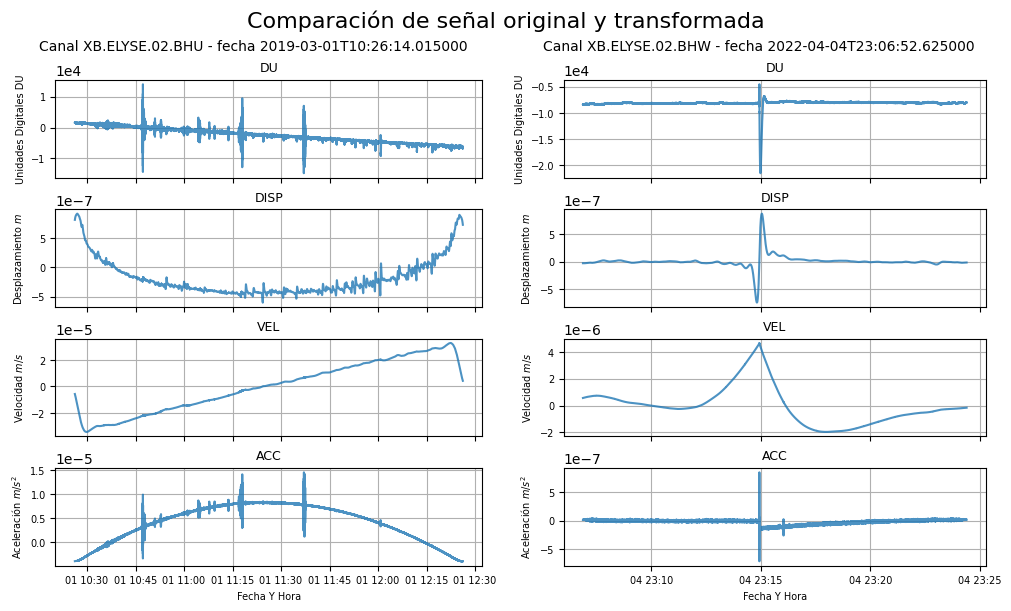

In [ ]:
fig = plt.figure(figsize=(10, 6), constrained_layout=True)
fig.suptitle('Comparación de señal original y transformada', fontsize=16)

subfigs = fig.subfigures(1, 2)

for sfig, i in zip(subfigs, [0, -1]):
    sfig.suptitle('Canal ' + seis_data["DU"][i].id + ' - fecha ' + seis_data["DU"][i].stats.starttime.isoformat(), fontsize=10)
    axs = sfig.subplots(len(seis_data.keys()), 1, sharex=True)
    ylabels = ["Unidades Digitales DU", "Desplazamiento $m$", "Velocidad $m/s$", "Aceleración $m/s^2$"]

    for output_unit, ax, ylabel in zip(seis_data.keys(), axs, ylabels):
        times = [(seis_data[output_unit][i].stats.starttime + s).datetime for s in seis_data[output_unit][i].times()]
        ax.plot(times, seis_data[output_unit][i].data, alpha=0.8)
        ax.set_title(output_unit, fontsize=9)
        ax.set_ylabel(ylabel, fontsize=7)
        ax.grid(True)
        ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
        ax.tick_params(axis='both', which='major', labelsize=7)

    ax.set_xlabel('Fecha Y Hora', fontsize=7)

plt.subplots_adjust(top=0.85, hspace=0.3)
plt.show()


También se puede aplicar un suavizado cónico de coseno en los extremos de la señal al realizar la transformación.

In [ ]:
pre_filt = [0.005, 0.01, 8, 10]  # para datos de 20 Hz
tapered_seis_data = transform_data(seis_data_stream, seis_inventories, taper_fraction=0.05, pre_filt=pre_filt)

La siguiente gráfica compara las distintas conversiones de la segunda traza de señales sísmicas:

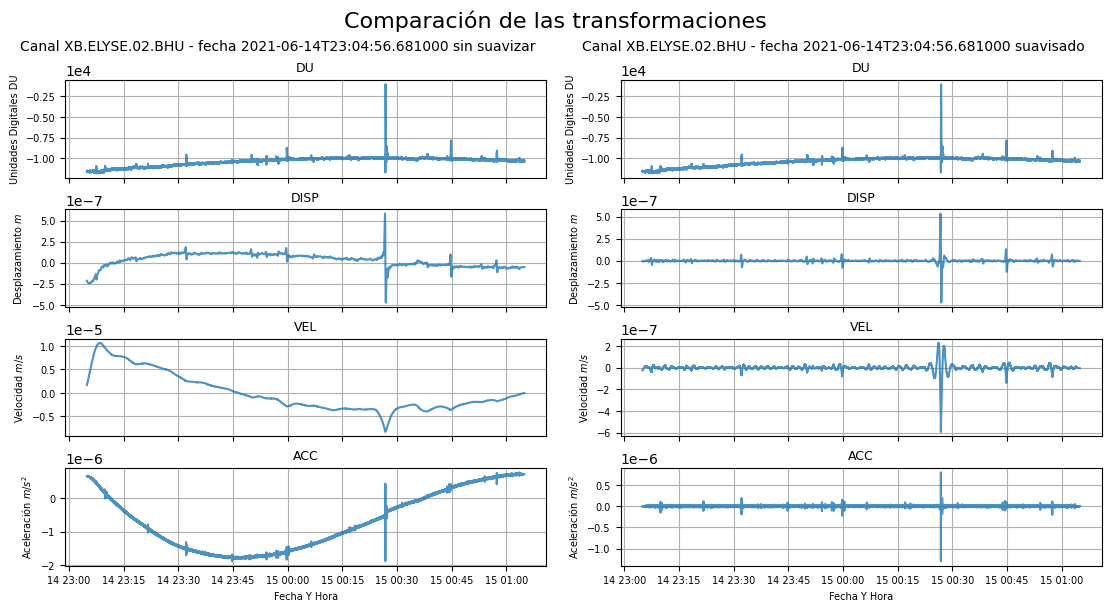

In [ ]:
fig = plt.figure(figsize=(11, 6), constrained_layout=True)
fig.suptitle('Comparación de las transformaciones', fontsize=16)

subfigs = fig.subfigures(1, 2)

for sfig, data, title_end in zip(subfigs, [seis_data, tapered_seis_data], [' sin suavizar', " suavisado"]):
    sfig.suptitle('Canal ' + data["DU"][1].id + ' - fecha ' + data["DU"][1].stats.starttime.isoformat() + title_end, fontsize=10)
    axs = sfig.subplots(len(data.keys()), 1, sharex=True)
    ylabels = ["Unidades Digitales DU", "Desplazamiento $m$", "Velocidad $m/s$", "Aceleración $m/s^2$"]

    for output_unit, ax, ylabel in zip(data.keys(), axs, ylabels):
        times = [(data[output_unit][1].stats.starttime + s).datetime for s in data[output_unit][1].times()]
        ax.plot(times, data[output_unit][1].data, alpha=0.8)
        ax.set_title(output_unit, fontsize=9)
        ax.set_ylabel(ylabel, fontsize=7)
        ax.grid(True)
        ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
        ax.tick_params(axis='both', which='major', labelsize=7)

    ax.set_xlabel('Fecha Y Hora', fontsize=7)

plt.subplots_adjust(top=0.85, hspace=0.3)
plt.show()

Otra transformación útil son los filtros de frecuencia, tanto de paso alto como de paso bajo, que permite eliminar el ruido de los extremos de la banda de frecuencia. Sin embargo, no hay valores claros para los limites del filtro, en este caso se utilizo de 0.01 a 50 como ejemplo, pero es necesario buscar los valores óptimos en la literatura.

In [ ]:
cutoff_low = 0.01
cutoff_high = 50

bandpass_seis_data = {k: v.copy() for k, v in tapered_seis_data.items()}
for k in bandpass_seis_data:
  bandpass_seis_data[k].filter(type='bandpass', freqmin=cutoff_low, freqmax=cutoff_high)

Este es el reslutado de forma gráfica, comparando las transformaciones de la tercer traza con suavizamiento:

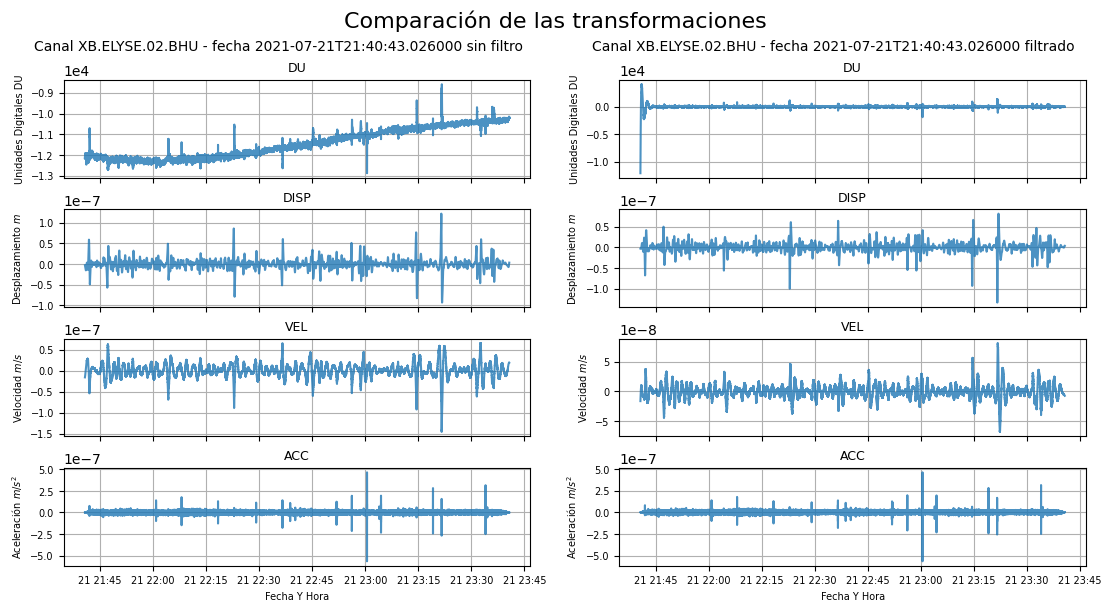

In [ ]:
fig = plt.figure(figsize=(11, 6), constrained_layout=True)
fig.suptitle('Comparación de las transformaciones', fontsize=16)

subfigs = fig.subfigures(1, 2)

for sfig, data, title_end in zip(subfigs, [tapered_seis_data, bandpass_seis_data], [' sin filtro', " filtrado"]):
    sfig.suptitle('Canal ' + data["DU"][2].id + ' - fecha ' + data["DU"][2].stats.starttime.isoformat() + title_end, fontsize=10)
    axs = sfig.subplots(len(data.keys()), 1, sharex=True)
    ylabels = ["Unidades Digitales DU", "Desplazamiento $m$", "Velocidad $m/s$", "Aceleración $m/s^2$"]

    for output_unit, ax, ylabel in zip(data.keys(), axs, ylabels):
        times = [(data[output_unit][2].stats.starttime + s).datetime for s in data[output_unit][2].times()]
        ax.plot(times, data[output_unit][2].data, alpha=0.8)
        ax.set_title(output_unit, fontsize=9)
        ax.set_ylabel(ylabel, fontsize=7)
        ax.grid(True)
        ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
        ax.tick_params(axis='both', which='major', labelsize=7)

    ax.set_xlabel('Fecha Y Hora', fontsize=7)

plt.subplots_adjust(top=0.85, hspace=0.3)
plt.show()